## Assignment Task

In [1]:
#importing all the necessary libraries
from datetime import timedelta
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob

In [2]:
#reading the video
capture = cv.VideoCapture('E:/Data Science/opencv/Videos/Car.mp4')

while True:
    isTrue, frame = capture.read() #reads the video frame by frame
    cv.imshow('Video', frame)
    
    if cv.waitKey(33) == 27:
        break
        
capture.release()
cv.destroyAllWindows()

### Saving keyframes of a video by filename being the timestamp

In [3]:
#if a video of duration 30 sec, saves 2 frames per second = 60 frames saved

saving_frames_per_second = 2

In [4]:
def format_timedelta(td):
    
     
    result = str(td)

    try:
        result, ms = result.split(".")
    except ValueError:
        return result + ".00".replace(":","-")

    ms = int(ms)
    ms = round(ms / 1e4)

    return f"{result}.{ms:02}".replace(":","-")

In [5]:
def get_saving_frames_durations(cap, saving_fps):
    duration_list = []
    #get the clip duration by dividing number of frames by the number of frames per second
    clip_duration = cap.get(cv.CAP_PROP_FRAME_COUNT)/cap.get(cv.CAP_PROP_FPS)
    
    #use np.arange() to make floating point steps
    
    for i in np.arange(0, clip_duration, 1/saving_fps):
        duration_list.append(i)
    return duration_list

In [6]:
def create_dir(path):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"ERROR: creating directory with name {path}")

In [7]:
def save_frame(video_path, save_dir):
    name = video_path.split("\\")[-1].split(".")[0]
    save_path = os.path.join(save_dir, name)
    create_dir(save_path)
    
    #make a folder by the name of the video file
    
    
    #read the video file
    
    cap = cv.VideoCapture(video_path)
    
    #get the fps of the video
    fps = cap.get(cv.CAP_PROP_FPS)
    
    # if the SAVING_FRAMES_PER_SECOND is above video FPS, then set it to FPS (as maximum)
    new_saving_frames_per_second = min(fps, saving_frames_per_second)
    
     # get the list of duration spots to save
    saving_frames_duration =  get_saving_frames_durations(cap, new_saving_frames_per_second)
    
    count = 0
    while True:
        is_read, frame = cap.read()
        if not is_read:
            #break out of the loop if there are no frames to read
            break
        #get the duration by dividing the frame count by the FPS
        frame_duration = count/fps
        
        try:
            #get the earliest duration to save
            closest_duration = saving_frames_duration[0]
        except IndexError:
            #the list is empty all duration frames were saved
            break
            
        if frame_duration >= closest_duration:
           #if closest duration is less than or equal to frame duration then save the frame
            frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
            cv.imwrite(f"{save_path}/{frame_duration_formatted}.jpg", frame)
            
            # drop the duration spot from the list, since this duration spot is already saved
            try:
                saving_frames_duration.pop(0)
            except IndexError:
                pass
        #increment the frame count
        count += 1

In [8]:
if __name__ == "__main__":
    video_paths = "E:/Data Science/opencv/Videos/Car.mp4"
    save_dir = "E:/Data Science/opencv/Videos"
    
    save_frame(video_paths, save_dir)

### maximum object timeframe detection using yolov3

In [9]:
#load yolo
net = cv.dnn.readNet("E:/Data Science/opencv/yolov3 (2).weights","E:/Data Science/opencv/yolov3 (2).cfg")
classes = []
with open('E:/Data Science/opencv/coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

In [10]:
classes

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [11]:
unconnectedLayers = net.getUnconnectedOutLayers()
layer_names = net.getLayerNames()
outputlayers = [layer_names[i - 1] for i in unconnectedLayers]

In [12]:
outputlayers

['yolo_82', 'yolo_94', 'yolo_106']

In [13]:
file_list = []
num_of_obj_list = []

img_paths = glob("E:/Data Science/opencv/Videos/car/*")
#count = 0
for path in img_paths:
    #loading image
    img = cv.imread(path)
    
    filename = path.split("\\")[-1]
    filename = filename.split(".")
    new_str = filename[0]+'.'+filename[1]
    
    height, width, channels = img.shape
    
    #detecting objects
    blob = cv.dnn.blobFromImage(img, 0.00392,(416,416),(0,0,0),True,crop=False)

    net.setInput(blob)
    outs = net.forward(outputlayers)

    #evaluation
    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5:
                #object detected
                center_x = int(detection[0]*width)
                center_y = int(detection[1]*height)
                w = int(detection[2]*width)
                h = int(detection[3]*height)

                
                #rectangle co-ordinaters
                x=int(center_x - w/2)
                y=int(center_y - h/2)

                
                boxes.append([x,y,w,h]) 
                confidences.append(float(confidence)) 
                class_ids.append(class_id) 
            
    #cv2.dnn.NMSBoxes(boxes,confidences,score_threshold,IOU_threshold)
    indexes = cv.dnn.NMSBoxes(boxes,confidences,0.4,0.5)#Non Max Suppressions

    file_list.append(new_str)
    num_of_obj_list.append(len(indexes))
    #print(count)
    #count += 1


timestamp having the highest number of objects: 0-00-33.52
number of objects detected: 13


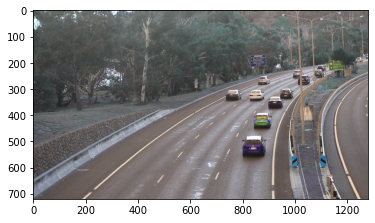

In [14]:
df = pd.DataFrame({'timestamp': file_list, 'object': num_of_obj_list })
idx = df['object'].idxmax()
image = cv.imread(f"E:/Data Science/opencv/Videos/car/{df['timestamp'][idx]}.jpg")
plt.imshow(image)
print(f"timestamp having the highest number of objects: {df['timestamp'][idx]}")
print(f"number of objects detected: {df['object'][idx]}")